### Import Libraries

In [1]:
import numpy as np
import glob, os
import pandas as pd
import inflect
import re
import time
# next we can import some sklearn libraries to start working with stuff
## transformers and pipline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
## model selectors
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
## models
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
## feature extractors
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from average_word_length_extractor import AverageWordLengthExtractor
from question_extractor import QuestionExtractor
from int_to_words_extractor import NumberStringExtractor
from greeting_extractor import GreetingExtractor
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from text_preprocessor import TextPreprocessor
from sentiment_extractor import SentimentExtractor
from ner_extractor import NERExtractor
# model testing
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix 
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score, brier_score_loss, recall_score, precision_score
from sklearn.utils.fixes import signature
# save model
from sklearn.externals import joblib
# plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline

/anaconda3/envs/aml/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

### Reading test data

In [3]:
test_files = glob.glob('../data/data_v1/TestCSV_Updated/*.csv')
test = pd.concat([pd.read_csv(fp).assign(test_set=re.split('_|, ',os.path.basename(fp))[0]) for fp in test_files])

In [4]:
test.head(3)

,stringList,speakerID,semanticType,leading,Symptom,PMH,MEDS,ALLG,FAMHx,lifestyle,...,GS4089,GS4090,GS4091,GS4092,GS4093,GS4094,GS4095,stringedQuestion,supportProvision,test_set
0,so I was wondering if you could tell me why yo...,doctor,openQuestion,no,no,no,no,no,no,no,...,0.122049,-0.030231,-0.014938,0.023475,-0.004900,-0.003502,0.034194,no,no,10
1,okay,patient,statement,no,no,no,no,no,no,no,...,0.081148,-0.030529,0.009020,0.026534,0.000665,0.012509,0.008983,no,no,10
2,um I lost like 15 pounds just really quickly i...,patient,statement,no,yes,no,no,no,no,no,...,0.042242,0.010893,0.018835,-0.019626,0.010086,0.002141,0.082543,no,no,10


In [5]:
# convert yes to True(1) and no to False(0)
test = test.replace(to_replace={'yes': 1, 'no': 0})

In [6]:
# remove test_set columns
test.drop(['test_set'], axis = 1, inplace=True)

In [7]:
# features over which we have to predict
prediction_columns = ['stringedQuestion',
                   'leading', 'Symptom', 'PMH', 'MEDS', 'ALLG', 'FAMHx', 'lifestyle',
                   'pysch', 'SOCHx', 'sexualHistory', 'substanceUse', 'PE', 'FORM',
                   'supportProvision', 'transition']

In [8]:
# extract doctor interactions
test = test.loc[test.speakerID == 'doctor']

In [9]:
# drop nas for now
test.dropna(inplace=True, axis = 1)

### Feature Selection

In [10]:
# select columns by data
X_test = test.drop(prediction_columns, axis=1)
unusable_columns = ['speakerID', 'case_ID']
X_test = X_test.drop(unusable_columns, axis=1)
# select x and y
y_test = test.loc[:, test.columns == prediction_columns[8]]

In [11]:
# check the balance for each prediction feature
for n,i in enumerate(prediction_columns):
    balance = test.loc[:, test.columns == prediction_columns[n]][i].value_counts()[1] / y_test.shape[0]
    print('%s: %0.3f%%'%(i, balance*100))

stringedQuestion: 2.687%
leading: 0.258%
Symptom: 24.651%
PMH: 4.961%
MEDS: 1.240%
ALLG: 0.724%
FAMHx: 3.669%
lifestyle: 1.964%
pysch: 2.532%
SOCHx: 2.842%
sexualHistory: 0.207%
substanceUse: 2.377%
PE: 10.853%
FORM: 12.196%
supportProvision: 2.274%
transition: 6.873%


### Import model

In [21]:
file_name = 'LightGBM-grid-search-20190427-134642.pkl'
# machine learning models
ml_pipeline = joblib.load('../model/20190427-134642/' + file_name)
# log file
log = pd.read_csv('../results/log.csv')

Classification report for classifier stringedQuestion:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1883
           1       0.77      0.58      0.66        52

   micro avg       0.98      0.98      0.98      1935
   macro avg       0.88      0.79      0.83      1935
weighted avg       0.98      0.98      0.98      1935




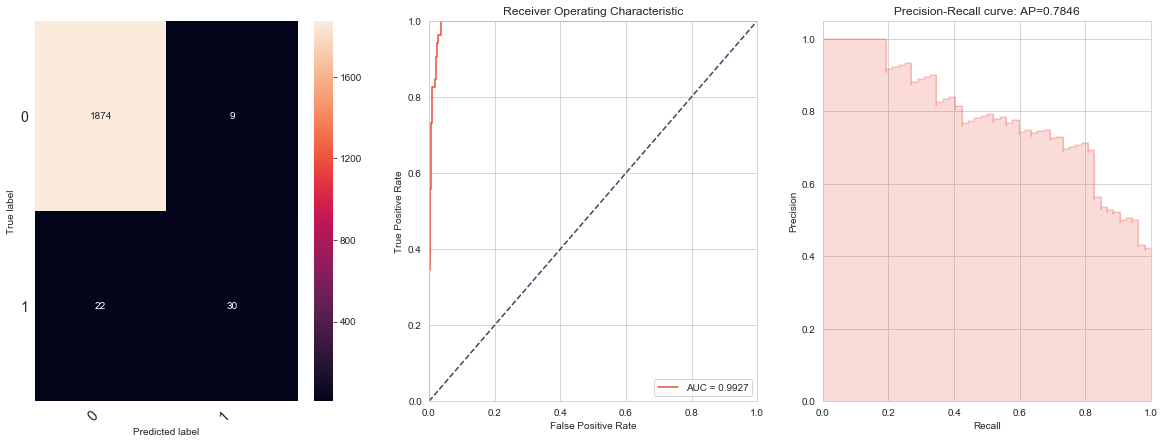

Classification report for classifier leading:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1930
           1       0.00      0.00      0.00         5

   micro avg       1.00      1.00      1.00      1935
   macro avg       0.50      0.50      0.50      1935
weighted avg       0.99      1.00      1.00      1935




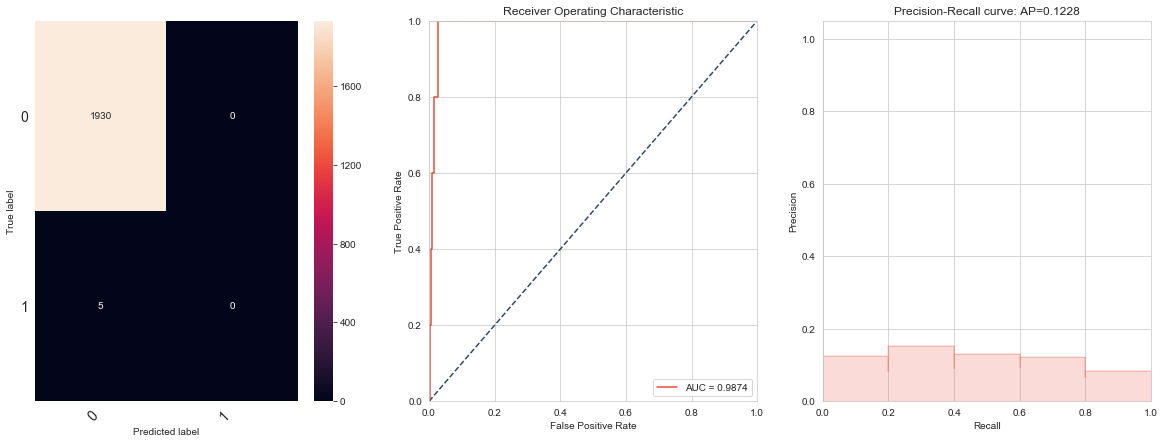

Classification report for classifier Symptom:
              precision    recall  f1-score   support

           0       0.76      0.97      0.85      1458
           1       0.46      0.08      0.13       477

   micro avg       0.75      0.75      0.75      1935
   macro avg       0.61      0.52      0.49      1935
weighted avg       0.69      0.75      0.68      1935




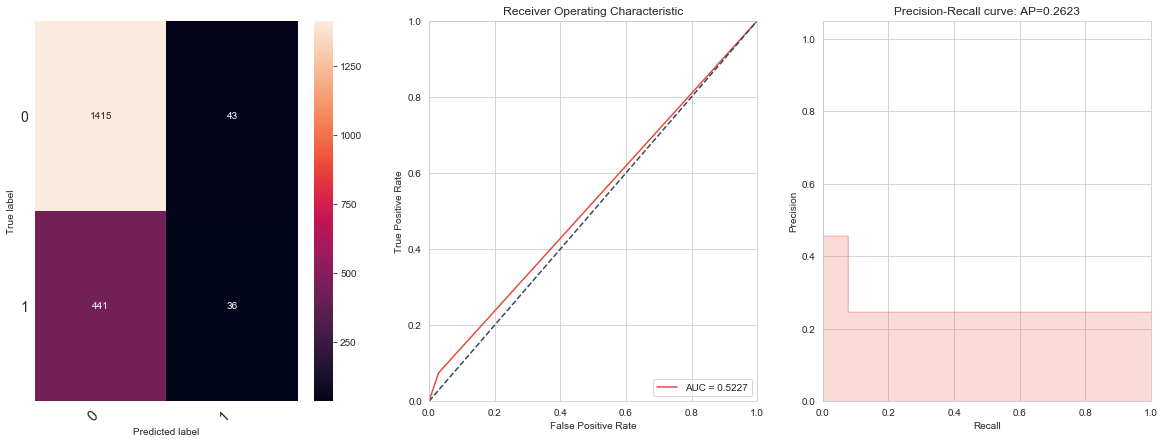

Classification report for classifier PMH:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1839
           1       0.00      0.00      0.00        96

   micro avg       0.95      0.95      0.95      1935
   macro avg       0.48      0.50      0.49      1935
weighted avg       0.90      0.95      0.93      1935




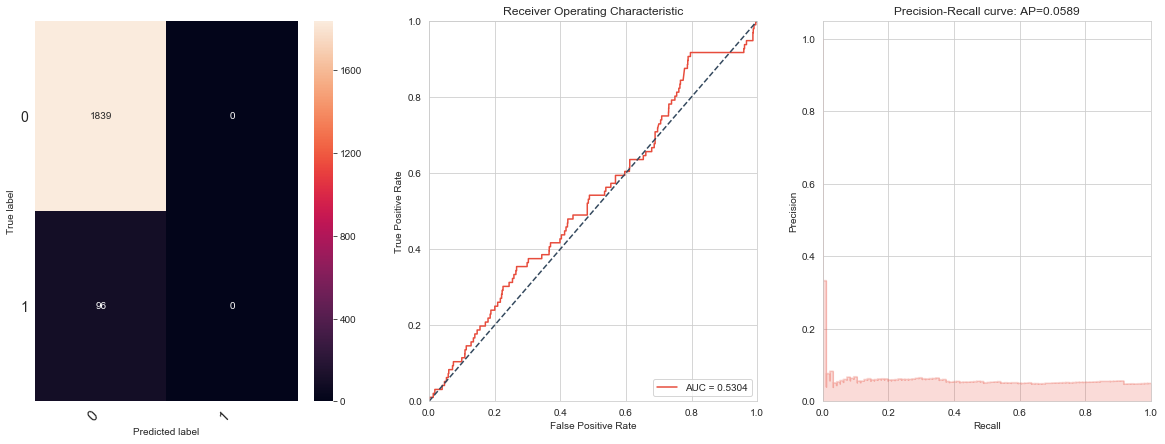

Classification report for classifier MEDS:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1911
           1       0.94      0.62      0.75        24

   micro avg       0.99      0.99      0.99      1935
   macro avg       0.97      0.81      0.87      1935
weighted avg       0.99      0.99      0.99      1935




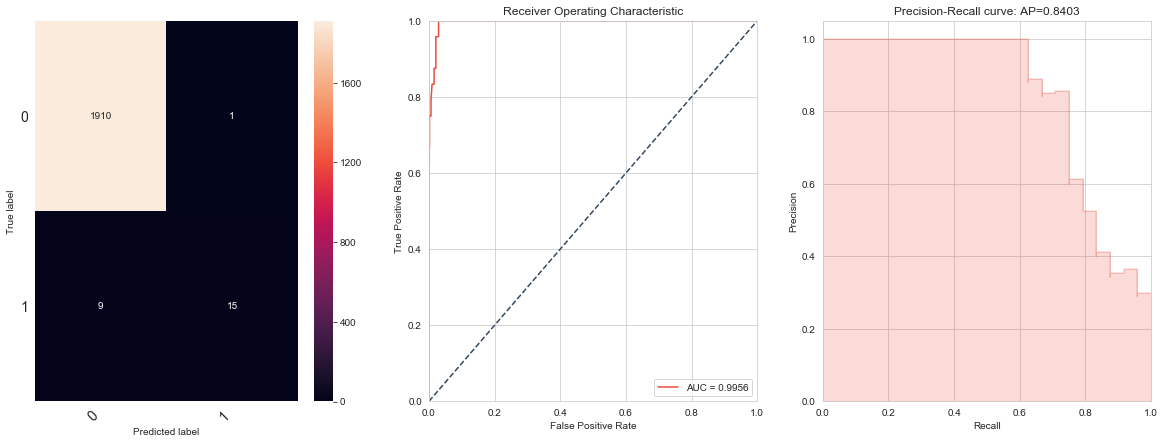

Classification report for classifier ALLG:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1921
           1       1.00      0.71      0.83        14

   micro avg       1.00      1.00      1.00      1935
   macro avg       1.00      0.86      0.92      1935
weighted avg       1.00      1.00      1.00      1935




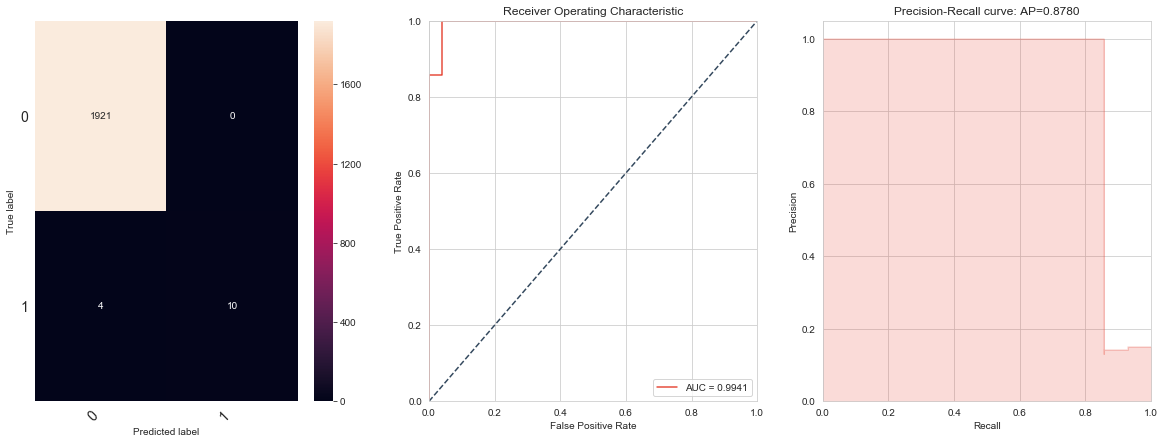

Classification report for classifier FAMHx:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1864
           1       0.93      0.79      0.85        71

   micro avg       0.99      0.99      0.99      1935
   macro avg       0.96      0.89      0.92      1935
weighted avg       0.99      0.99      0.99      1935




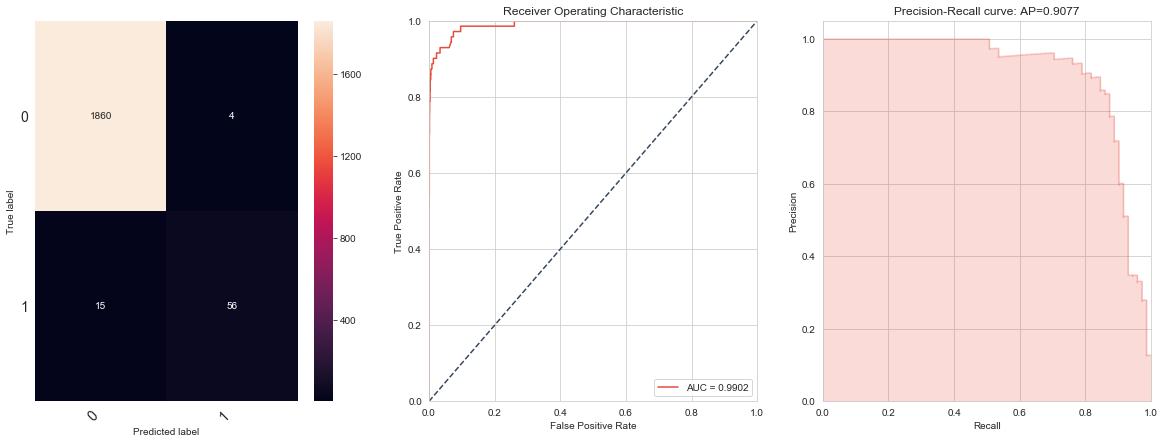

Classification report for classifier lifestyle:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1897
           1       0.86      0.66      0.75        38

   micro avg       0.99      0.99      0.99      1935
   macro avg       0.93      0.83      0.87      1935
weighted avg       0.99      0.99      0.99      1935




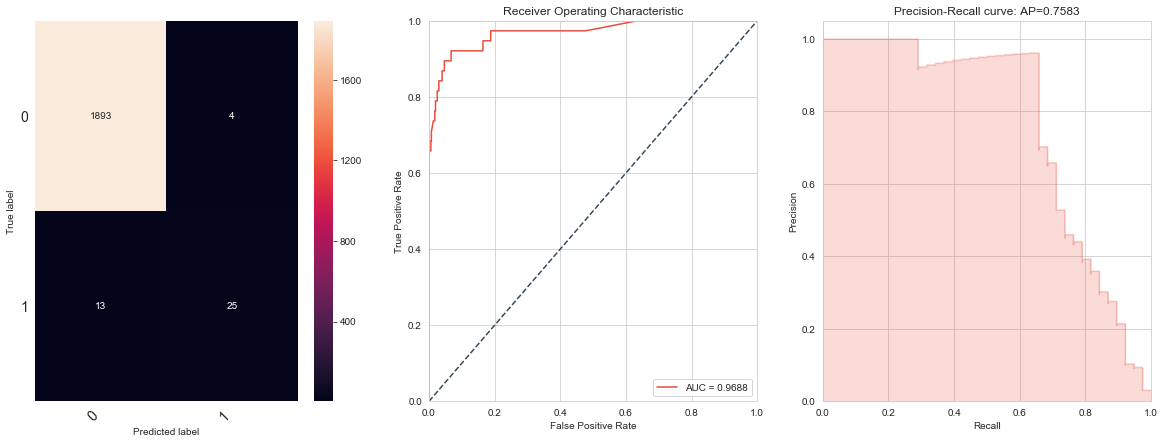

Classification report for classifier pysch:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1886
           1       0.96      0.47      0.63        49

   micro avg       0.99      0.99      0.99      1935
   macro avg       0.97      0.73      0.81      1935
weighted avg       0.99      0.99      0.98      1935




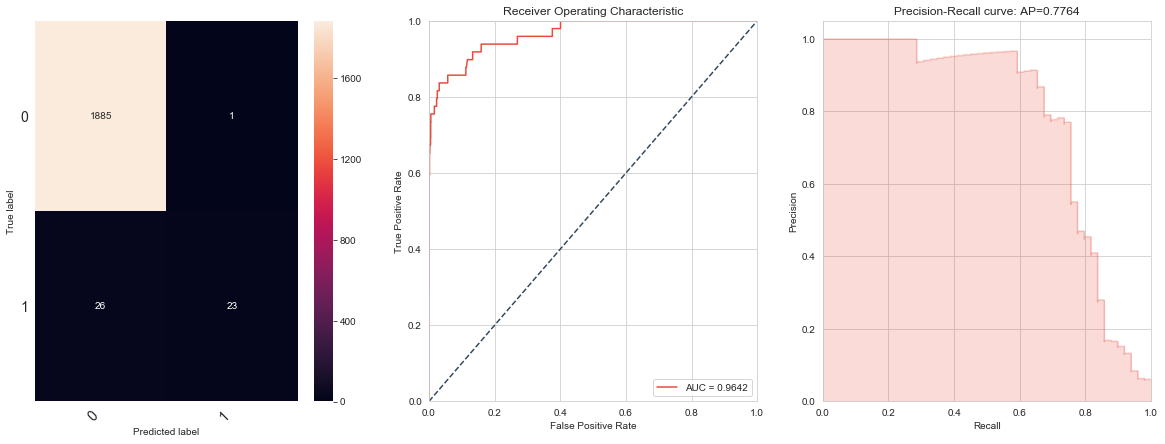

Classification report for classifier SOCHx:
              precision    recall  f1-score   support

           0       0.96      0.77      0.86      1880
           1       0.00      0.04      0.01        55

   micro avg       0.75      0.75      0.75      1935
   macro avg       0.48      0.40      0.43      1935
weighted avg       0.94      0.75      0.83      1935




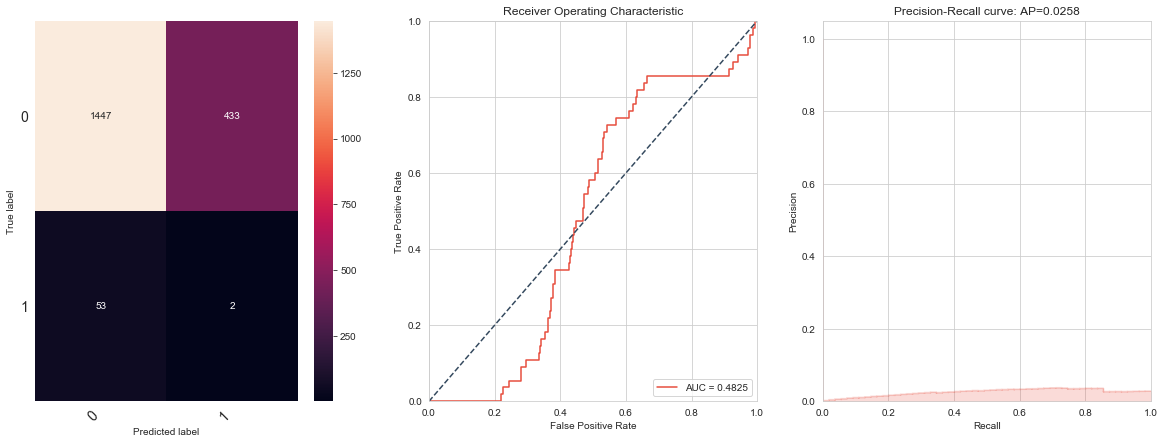

Classification report for classifier sexualHistory:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      1931
           1       0.00      0.00      0.00         4

   micro avg       0.96      0.96      0.96      1935
   macro avg       0.50      0.48      0.49      1935
weighted avg       1.00      0.96      0.98      1935




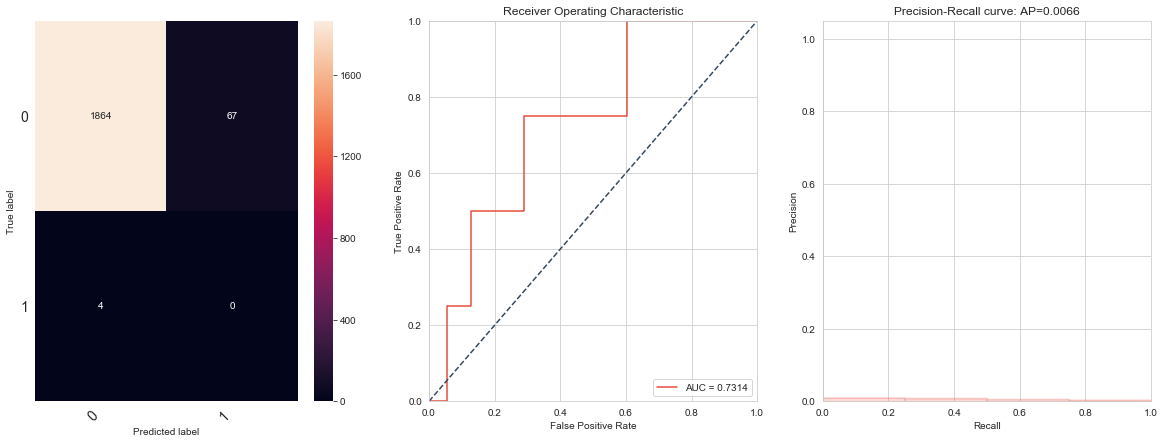

Classification report for classifier substanceUse:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1889
           1       0.00      0.00      0.00        46

   micro avg       0.97      0.97      0.97      1935
   macro avg       0.49      0.50      0.49      1935
weighted avg       0.95      0.97      0.96      1935




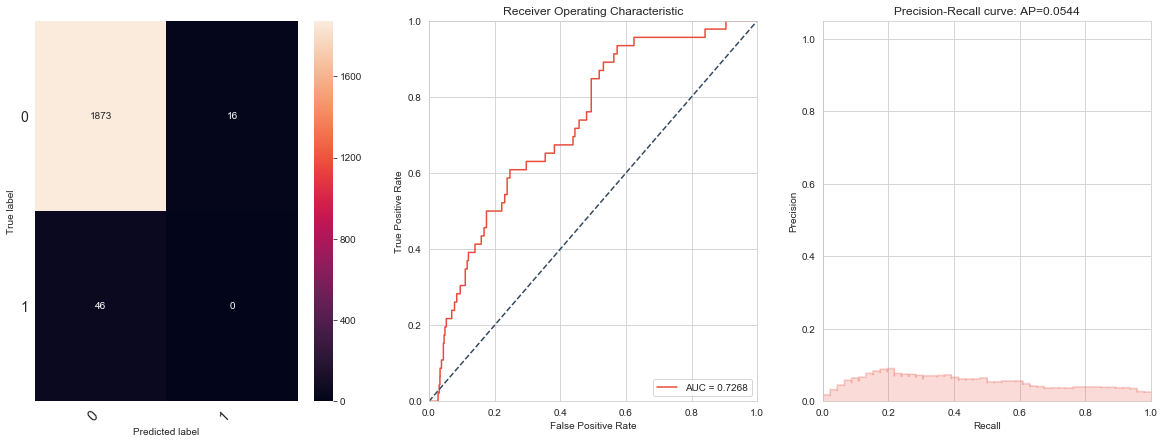

Classification report for classifier PE:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94      1725
           1       0.00      0.00      0.00       210

   micro avg       0.89      0.89      0.89      1935
   macro avg       0.45      0.50      0.47      1935
weighted avg       0.79      0.89      0.84      1935




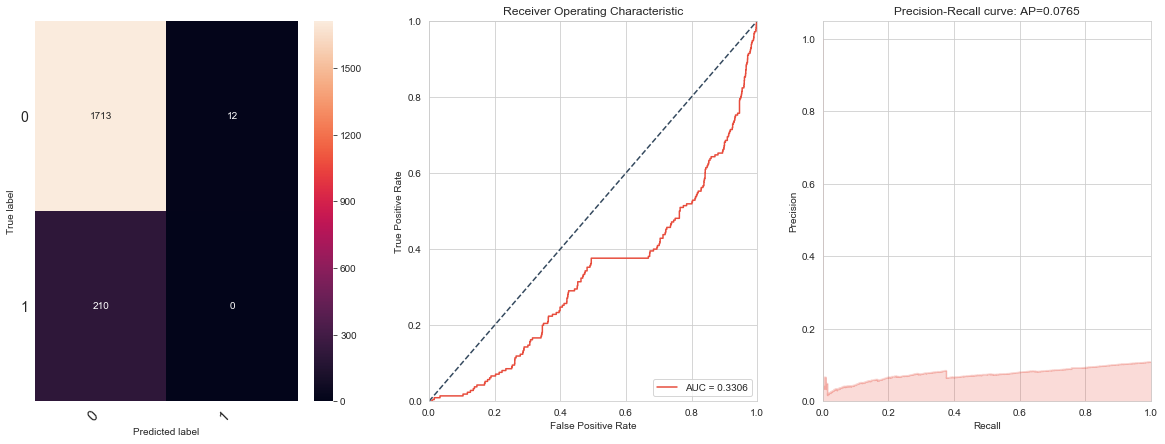

Classification report for classifier FORM:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1699
           1       0.68      0.56      0.61       236

   micro avg       0.91      0.91      0.91      1935
   macro avg       0.81      0.76      0.78      1935
weighted avg       0.91      0.91      0.91      1935




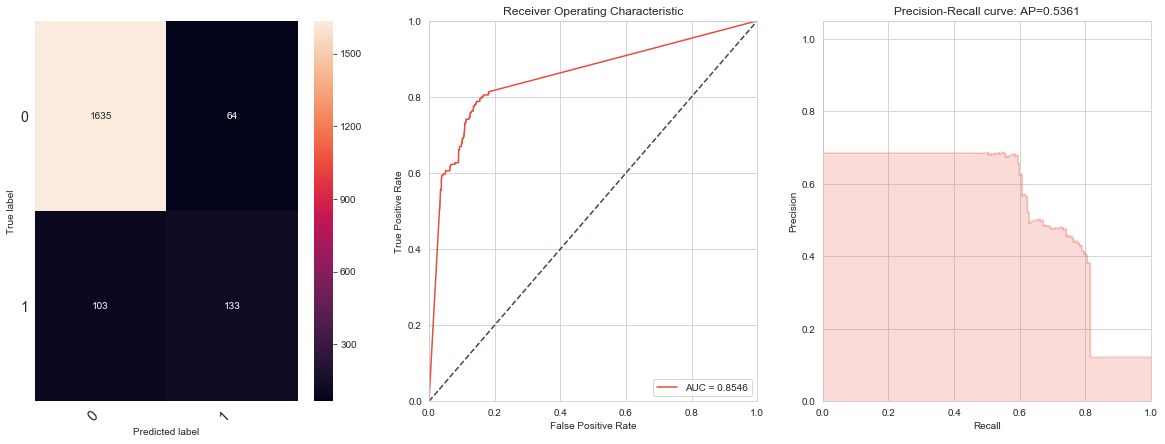

Classification report for classifier supportProvision:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1891
           1       0.82      0.52      0.64        44

   micro avg       0.99      0.99      0.99      1935
   macro avg       0.91      0.76      0.82      1935
weighted avg       0.99      0.99      0.99      1935




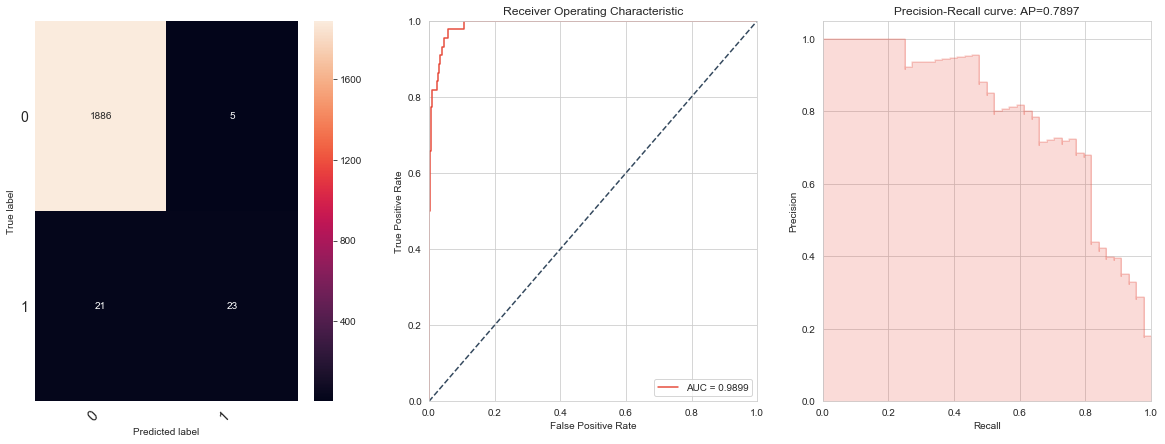

Classification report for classifier transition:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      1802
           1       0.00      0.00      0.00       133

   micro avg       0.90      0.90      0.90      1935
   macro avg       0.46      0.48      0.47      1935
weighted avg       0.87      0.90      0.88      1935




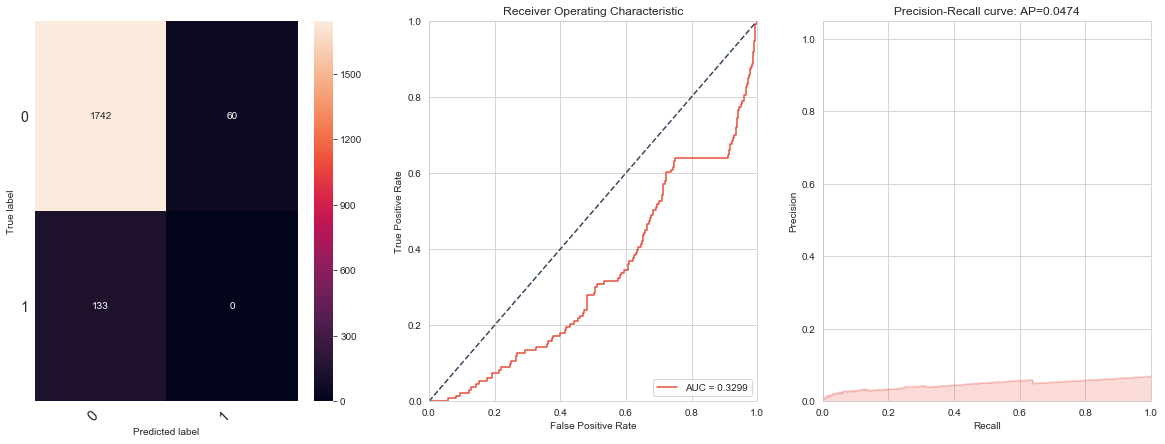

In [22]:
for n, i in enumerate(prediction_columns):
    y_test = test.loc[:, test.columns == prediction_columns[n]]
    
    # get predictions
    probs = ml_pipeline[i].predict_proba(X_test)
    preds = probs[:,1]
    y_pred = ml_pipeline[i].predict(X_test)
    
    print("Classification report for classifier %s:\n%s\n"
      % (i, classification_report(y_test, y_pred)))
    
    fig = plt.figure(figsize=(20, 7))

    # confusion matrix
    plt.subplot(1, 3, 1)
    df_cm = pd.DataFrame(
        confusion_matrix(y_test, y_pred), 
        index=[0, 1], 
        columns=[0, 1], 
    )
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # roc curve
    plt.subplot(1, 3, 2)
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, '#e74c3c', label = 'AUC = %0.4f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--', color = '#34495e')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

    # p-r curve
    plt.subplot(1, 3, 3)
    average_precision = average_precision_score(y_test, preds)
    precision, recall, _ = precision_recall_curve(y_test, preds)

    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    plt.step(recall, precision, color='#e74c3c', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='#e74c3c', **step_kwargs)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve: AP={0:0.4f}'.format(
              average_precision))

    plt.show()

    # save model performance to log file
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    brier_score = brier_score_loss(y_test, y_pred)

    log = log.append(pd.Series([file_name, i, '../model/' + file_name, accuracy, f1, recall, precision, roc_auc, average_precision, brier_score], index=log.columns), ignore_index=True)

In [24]:
# save to log
log.to_csv('../results/log.csv', index=False)